In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from numpy import genfromtxt
import numpy as np
import pandas as pd
import csv

interbankExposure = pd.read_csv('interbankExposures.csv', header=None)
bankEquities = pd.read_csv('bankEquities.csv', header=None)
bankExternalAsset = pd.read_csv('externalAssets.csv', header=None)


In [2]:
import sys, threading
sys.setrecursionlimit(10**7) # max depth of recursion
threading.stack_size(2**27)

0

In [3]:
##Get the interbank asset 
G = nx.DiGraph(interbankExposure.values)
nnodes = G.number_of_nodes() #145
out_degrees = [G.out_degree(n) for n in G.nodes()]
in_degrees = [G.in_degree(n) for n in G.nodes()]

# Get in-degree of each bank before shock applied 
in_Degree = pd.DataFrame(G.in_degree(weight= 'weight'))
# in_Degree = in_Degree.rename(columns={0:'nodes',1:'0'})
# in_Degree = in_Degree.drop(columns={'nodes'})
in_Degree = in_Degree.T
in_Degree

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,0.00,1.0,2.0,3.0,4.00,5.0,6.0,7.0,8.00,9.00,...,135.00,136.0,137.00,138.00,139.0,140.0,141.0,142.00,143.0,144.0
1,538218.69,7351.7,39050.7,85674483.0,460659.54,1238360.5,16031089.0,95791798.0,753818.56,565121.06,...,133173.62,89665235.0,266487.57,951698.84,114617.8,75172808.0,71611906.0,303785.69,3836714.3,21025428.6


In [4]:
## Get the interbank liabilities
out_Degree = pd.DataFrame(G.out_degree(weight= 'weight'))
# out_Degree = out_Degree.rename(columns={0:'nodes',1:'0'})
# out_Degree = out_Degree.drop(columns={'nodes'})
out_Degree = out_Degree.T
out_Degree

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,0.0,1.0,2.0,3.0,4.00,5.00,6.0,7.0,8.00,9.0,...,135.0,136.0,137.00,138.0,139.0,140.0,141.0,142.00,143.00,144.0
1,0.0,23025.0,23538.0,177169742.5,1084774.79,894264.49,9596575.2,155700407.0,982122.46,1187713.3,...,186295.8,7279935.1,231587.95,9066066.6,47821.0,43059152.3,101533088.0,589663.75,720921.42,24406140.7


In [5]:
## To computer external liabilities 
# External_liability = bankExteranlAsset + in degree - out_degree - bankEquities
external_liability = pd.DataFrame(index=range(1),columns=range(145))
external_liability= external_liability.add(bankExternalAsset, fill_value=0)
external_liability = external_liability.sub(bankEquities, fill_value=0)
external_liability = pd.DataFrame(external_liability.loc[0]+in_Degree.loc[1])
external_liability = pd.DataFrame(external_liability[0]-out_Degree.loc[1])
external_liability=external_liability.T
external_liability
#drop negative external_liability banks 
notdefaulted_external_liability = external_liability[external_liability[:]>0].dropna(axis=1)
defautled_external_liability = external_liability[external_liability[:]<=0].dropna(axis=1)


In [6]:
defautled_external_liability

,10,11,22,24,35,49,52,53,64,77,90,92,98,105,114,125,127,138
0,-34248.07,-2847008.5,-2357571.7,-3113241.5,-1254728.8,-152830.5,-2847489.83,-20651114.12,-3169523.98,-4997250.3,-767627.95,-1721970.7,-44794083.3,-4015397.3,-1514744.5,-6645171.5,-1494865.7,-4821777.76


In [7]:
#applied shock to system
defaulters = pd.DataFrame(index=range(1),columns=range(145))
notdefaulters = pd.DataFrame(index=range(1),columns=range(145))
shock =550000 #assume every bank hit by the same amount
for i in bankEquities: 
    bankEquities[i] = bankEquities[i]- shock
bankEquities

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,-84290.0,-545563.3,-536841,15679000.0,-111580.0,-278700.0,7022800.0,13717000.0,-450420,-371680.0,...,-517188,31573000.0,149090.0,-34690.0,-535741,10832000.0,13483000.0,-420570.0,324880.0,26305000.0


In [8]:
##Get defaulters and not_defaulters lists
notdefaulters = notdefaulters.reindex(notdefaulted_external_liability.columns,axis=1)
defaulters = notdefaulters.reindex(defautled_external_liability.columns,axis=1)
bankEquities = bankEquities.reindex(notdefaulted_external_liability.columns,axis=1)


In [9]:
defaulters

,10,11,22,24,35,49,52,53,64,77,90,92,98,105,114,125,127,138
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
notdefaulters = bankEquities[bankEquities.iloc[0:]>0]
notdefaulters = notdefaulters.dropna(axis=1)
notdefaulters

,3,6,7,13,20,21,25,27,29,31,...,128,129,131,132,136,137,140,141,143,144
0,15679000.0,7022800.0,13717000.0,3767500.0,1850900.0,476500.0,185790.0,47148000.0,2501400.0,9443200.0,...,26945000.0,5516700.0,595800.0,1078600.0,31573000.0,149090.0,10832000.0,13483000.0,324880.0,26305000.0


In [11]:
defaulters = bankEquities[bankEquities.iloc[0:]<=0]
defaulters = defaulters.dropna(axis=1)
defaulters

,0,1,2,4,5,8,9,12,14,15,...,118,119,123,126,130,133,134,135,139,142
0,-84290.0,-545563.3,-536841,-111580.0,-278700.0,-450420,-371680.0,-182480.0,-190680.0,-425720.0,...,-422070.0,-456206,-334090.0,-481349,-435070.0,-335500.0,-103950.0,-517188,-535741,-420570.0


In [12]:
##Create empty list for updated defaulters
newBankEquity = pd.DataFrame(index=range(1),columns=range(145))
newbanklist = pd.DataFrame(index=range(1),columns=range(145))
defaulteroutDegree = pd.DataFrame(index=range(1),columns=range(145))
notdefaulted_external_asset = pd.DataFrame(index=range(1),columns=range(145))

externallliability = equity - externalasset -indegree + outdegree\
equity = externalasset + indegree - outdegre -externalliabilty

In [13]:
### need to get only the external liability of banks that are not defaulted!! 
notdefaulted_external_asset = bankExternalAsset.reindex(notdefaulters.columns,axis=1) 
### Update Bank equity by deducting external liability of not defaulted banks 
newBankEquity = newBankEquity.sub(notdefaulted_external_liability, fill_value=0)
## Update bank's equity by adding external asset of not defaulted banks 
newBankEquity= newBankEquity.add(notdefaulted_external_asset, fill_value=0)
## Furfine function 
def furfine(defaulters, notdefaulters, newBankEquity, newbanklist,defaulteroutDegree,interbankExposure, bankExternalAsset,external_liability, in_Degree, out_Degree):
    #Reindex to only include not defualted banks interbank asset and interbank liabilities
    notdefaulters_inDegree = in_Degree.reindex(notdefaulters.columns,axis=1) 
    notdefaulters_outDegree = out_Degree.reindex(notdefaulters.columns,axis=1)
    #Calculate each bank's interbank liabilities from defaulter 
    for i in defaulters:
        sumDebt = sum(interbankExposure.loc[i,0:])
        defaulteroutDegree[i] = sumDebt
    #update bank equity 
    #equity= interbank assets(in degree)- defualted out degree -interbank liabilities(out degree)
    newBankEquity = newBankEquity.sub(defaulteroutDegree, fill_value=0)
    newBankEquity = pd.DataFrame(notdefaulters_inDegree.loc[1]+newBankEquity.loc[0])
    newBankEquity = pd.DataFrame(newBankEquity[0]-notdefaulters_outDegree.loc[1]).T
    newbanklist = newBankEquity[newBankEquity[:]>0].dropna(axis=1)
    if len(newbanklist.T)==len(notdefaulters.T): #check if new defaulted bank list is the same as the old list
        return notdefaulters  #Return banks that are not defaulted 
    else: 
        #Update the new defaulted and not defulated bank lists and enter the loop again 
        newBankEquity = newbanklist 
        defaulters = newBankEquity[newBankEquity[:]<=0].dropna(axis=0)
        notdefaulters = newBankEquity[newBankEquity[:]>0].dropna(axis=0)
    return furfine(defaulters,notdefaulters,newBankEquity,newbanklist,defaulteroutDegree,interbankExposure,bankExternalAsset,external_liability,in_Degree,out_Degree)




In [14]:
x = furfine(defaulters,notdefaulters,  newBankEquity, newbanklist,defaulteroutDegree,interbankExposure, bankExternalAsset,external_liability, in_Degree, out_Degree)
x

,3,6,7,13,20,21,25,27,29,31,...,128,129,131,132,136,137,140,141,143,144
0,15679000.0,7022800.0,13717000.0,3767500.0,1850900.0,476500.0,185790.0,47148000.0,2501400.0,9443200.0,...,26945000.0,5516700.0,595800.0,1078600.0,31573000.0,149090.0,10832000.0,13483000.0,324880.0,26305000.0


<AxesSubplot:xlabel='Shock', ylabel='Number of not defaulted banks '>

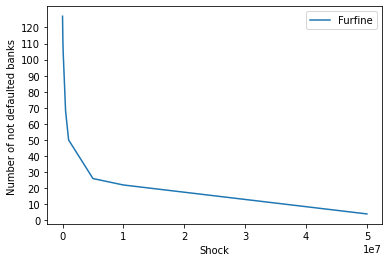

In [15]:
furfineGraph = pd.DataFrame({'Furfine': [127,113, 105,68,50, 26,22,4],}, 
                  index=[0,50000,100000,500000,1000000,5000000,10000000,50000000])
furfineGraph.plot.line(yticks = range(0,130,10), xlabel='Shock', ylabel= 'Number of not defaulted banks ')
